# Download and process the Bay Area's street network

In [1]:
import osmnx as ox, pandas as pd, geopandas as gpd, requests, os, zipfile
ox.config(use_cache=True, log_console=True)

In [2]:
# point to the shapefile for counties
counties_shapefile_url = 'http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_county_500k.zip'

# identify bay area counties by fips code
bayarea = {'Alameda':'001',
           'Contra Costa':'013',
           'Marin':'041',
           'Napa':'055',
           'San Francisco':'075',
           'San Mateo':'081',
           'Santa Clara':'085',
           'Solano':'095',
           'Sonoma':'097'}

## Download and extract the counties shapefile if it doesn't already exist, then load it

In [3]:
counties_shapefile_zip = counties_shapefile_url[counties_shapefile_url.rfind('/') + 1 :]
counties_shapefile_dir = counties_shapefile_zip[: counties_shapefile_zip.rfind('.zip')]
if not os.path.exists(counties_shapefile_dir):
    response = requests.get(counties_shapefile_url)
    with open(counties_shapefile_zip, 'wb') as f:
        f.write(response.content)
        with zipfile.ZipFile(counties_shapefile_zip, 'r') as zip_file:
            zip_file.extractall(counties_shapefile_dir)
    os.remove(counties_shapefile_zip)

In [4]:
counties = gpd.read_file(counties_shapefile_dir)
len(counties)

3233

In [5]:
# retain only those tracts that are in the bay area counties
mask = (counties['STATEFP'] == '06') & (counties['COUNTYFP'].isin(bayarea.values()))
gdf_bay = counties[mask]
len(gdf_bay)

9

## Download the street network

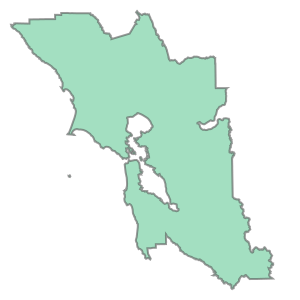

In [6]:
bayarea_polygon = gdf_bay.unary_union
bayarea_polygon_proj, crs = ox.project_geometry(bayarea_polygon)
bayarea_polygon_proj

In [7]:
G = ox.graph_from_polygon(bayarea_polygon, network_type='drive_service')

## Summary stats and save to disk

We started with 1,617,109 nodes and 3,175,573 edges before simplification.

In [8]:
pd.Series(ox.basic_stats(G, area=bayarea_polygon_proj.area))

circuity_avg                                                             1.12266
count_intersections                                                       257459
edge_density_km                                                          5832.01
edge_length_avg                                                           127.77
edge_length_total                                                     1.0768e+08
intersection_density_km                                                  13.9441
k_avg                                                                      4.887
m                                                                         842763
n                                                                         344900
node_density_km                                                            18.68
self_loop_proportion                                                  0.00735438
street_density_km                                                        3204.61
street_length_avg           

In [ ]:
# save it as graphml to use in igraph and other network analysis tools
ox.save_graphml(G, filename='bayarea.graphml')

In [ ]:
# save it as shapefile for GIS (this takes a long time with big graphs)
ox.save_graph_shapefile(G, filename='bayarea')